### This lesson is  based (almost copied) on fastai DL course by Jeremy Howard! His course his highly recommended!

# Transfer Learning

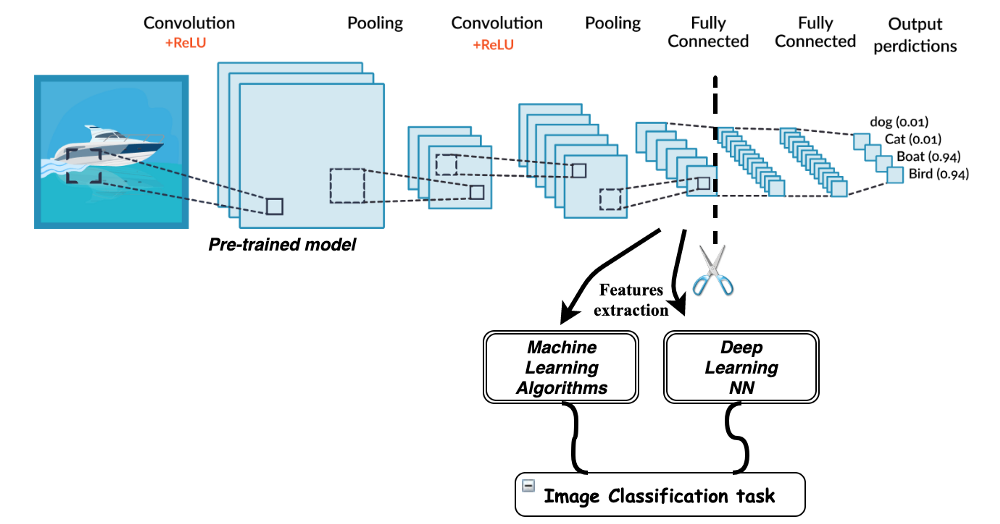

In [71]:
# taken from here: https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/
from IPython.display import SVG, display
from IPython.display import Image
Image(filename='figs/Transfer_learning.png', width=700)





### Transfer learning is a technique where you use a model trained on a very large dataset (usually ImageNet in computer vision) and then adapt it to your own dataset.

In [114]:
from fastai.vision import *
from fastai.metrics import error_rate

## Getting the data

In [115]:
path = untar_data(URLs.CIFAR); path


PosixPath('/Users/yani/.fastai/data/cifar10')

In [116]:
path.ls()

[PosixPath('/Users/yani/.fastai/data/cifar10/test'),
 PosixPath('/Users/yani/.fastai/data/cifar10/models'),
 PosixPath('/Users/yani/.fastai/data/cifar10/labels.txt'),
 PosixPath('/Users/yani/.fastai/data/cifar10/train')]

## Defining the databunch 

In [117]:
bs = 64 # batch size
img_size = 24 # image size

In [126]:
data = ImageDataBunch.from_folder(path,  valid='test', ds_tfms=get_transforms(),size=img_size, bs = bs) 
# normalising the dataset using the same normalisation applied to the imagenet dataset
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
cat,cat,cat,cat,cat
Path: /Users/yani/.fastai/data/cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24),Image (3, 24, 24)
y: CategoryList
cat,cat,cat,cat,cat
Path: /Users/yani/.fastai/data/cifar10;

Test: None

### DataBunch object that is used inside Learner to train a model. This is the generic class, that can take any kind of fastai Dataset or DataLoader. 


## Looking at the data

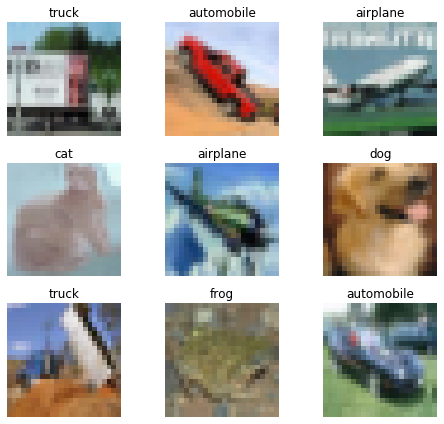

In [127]:
data.show_batch(rows=3, figsize=(7,6))


## Data augmentation (explenation and code taken from [here](https://docs.fast.ai/vision.transform.html#get_transforms))
### Data augmentation is perhaps the most important regularization technique when training a model for Computer Vision: instead of feeding the model with the same pictures every time, we do small random transformations (a bit of rotation, zoom, translation, etc...) that don't change what's inside the image 

In [144]:
# Please change path to the relevant path in your computer!
def get_ex(): return open_image('/Users/yani/.fastai/data/cifar10/test/dog/321_dog.png')
def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

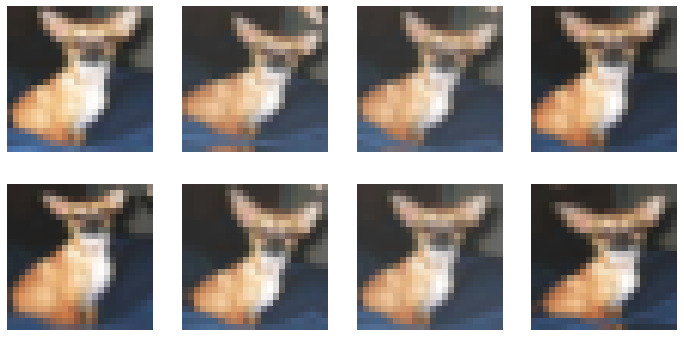

In [145]:
# plots_f(2, 4, 12, 6, size=24)


In [128]:
print(data.classes)
len(data.classes),data.c

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(10, 10)

In [129]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

In [122]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Changing the weights only in the last few fully-connected layers

In [123]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 12, 12]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 12, 12]         128        True      
______________________________________________________________________
ReLU                 [64, 12, 12]         0          False     
______________________________________________________________________
MaxPool2d            [64, 6, 6]           0          False     
______________________________________________________________________
Conv2d               [64, 6, 6]           36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 6, 6]           128        True      
______________________________________________________________________
ReLU                 [64, 6, 6]           0          False     
___________________________________________________

### If you wander why the batchnormalization is trainble - read [here](https://forums.fast.ai/t/why-are-batchnorm-layers-set-to-trainable-in-a-frozen-model/46560)

In [124]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


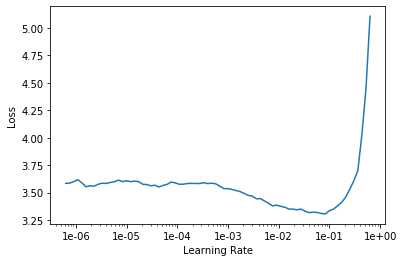

In [125]:
learn.recorder.plot()

### From fastai:
#### Train Learner over a few iterations. Start with a very low start_lr and change it at each mini-batch until it reaches a very high end_lr. Recorder will record the loss at each iteration. Plot those losses against the learning rate to find the optimal value before it diverges.

### We want to choose a learning rate that has the steepest descent (so the losses reduced as fast as possible)



[here](https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0) and [here](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) you can see more explenations about choosing the right learning rate

In [16]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.649132,1.540377,0.545600,03:58


In [17]:
learn.save('stage-1')

### To understand the One cycle policy - read more [here](https://sgugger.github.io/the-1cycle-policy.html)

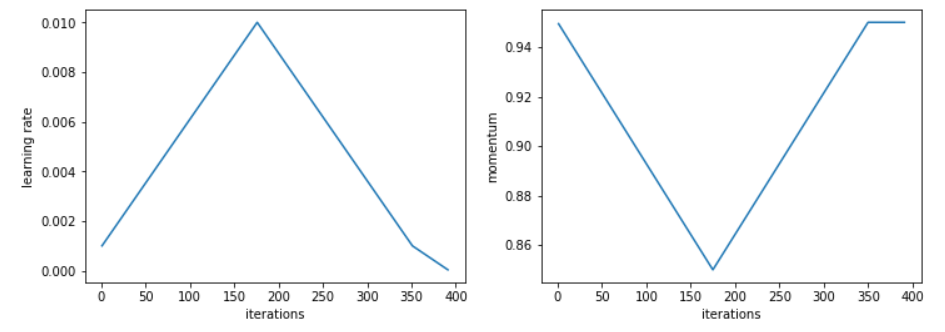

In [24]:
# Image taken from - https://docs.fast.ai/callbacks.one_cycle.html
Image(filename='figs/onecycle_params.png', width=700)

### it makes a difference if we run fit_one_cycle(1) twice or  fit_one_cycle(2) once!

In [130]:
learn2 = cnn_learner(data, models.resnet18, metrics=error_rate)
learn2.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.855321,1.640461,0.583400,04:03
1,1.523808,1.351570,0.487100,03:51
2,1.351469,1.233529,0.439600,03:46
3,1.326194,1.216707,0.434400,03:43


In [132]:
learn2.save('learn2-stage-1')

### If you wander why the validation loss is smaller than the training loss - please read  [here](https://twitter.com/aureliengeron/status/1110839223878184960) and [here](https://forums.fast.ai/t/training-loss-validation-loss/39698/21) 

In [133]:
interp = ClassificationInterpretation.from_learner(learn2)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

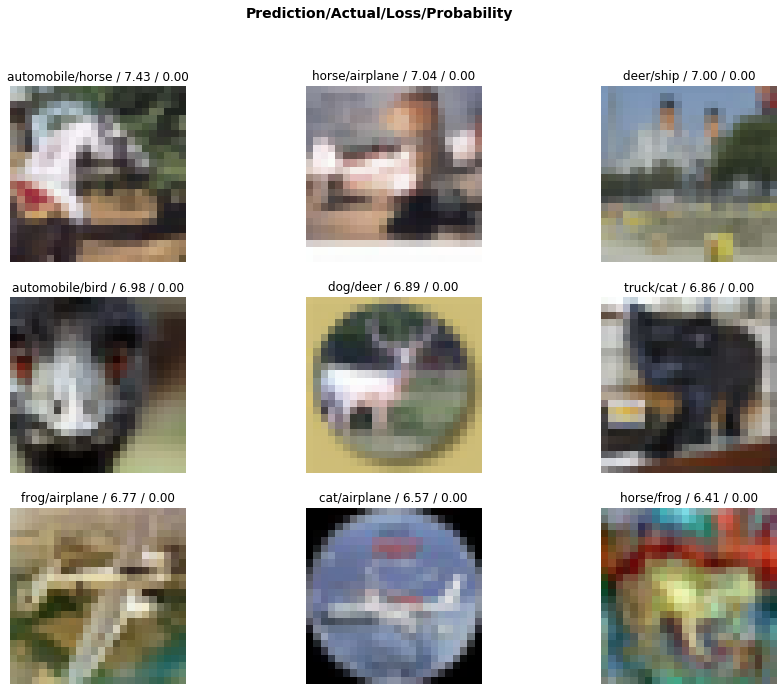

In [134]:
interp.plot_top_losses(9, figsize=(15,11))


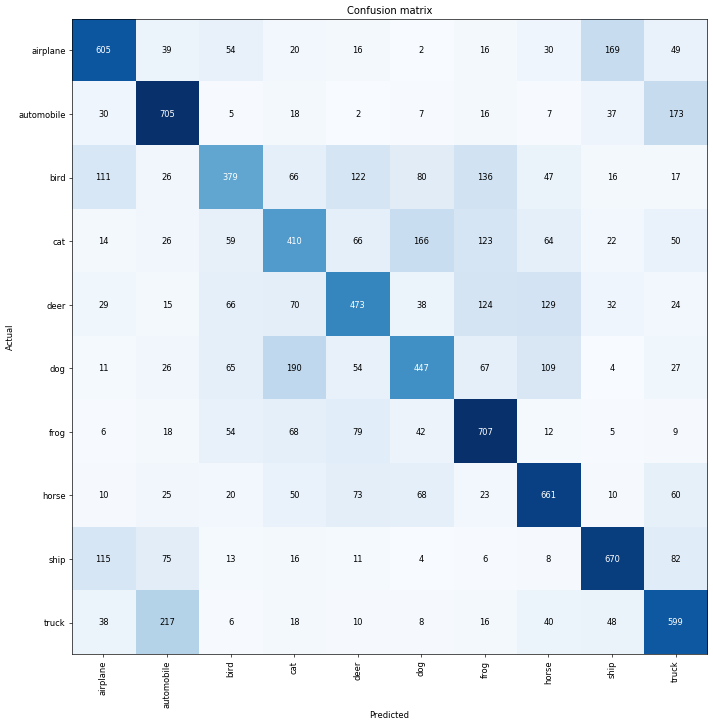

In [135]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


### Changing the weights of all layers

In [136]:
learn2.unfreeze()

In [137]:
learn2.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 12, 12]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 12, 12]         128        True      
______________________________________________________________________
ReLU                 [64, 12, 12]         0          False     
______________________________________________________________________
MaxPool2d            [64, 6, 6]           0          False     
______________________________________________________________________
Conv2d               [64, 6, 6]           36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 6, 6]           128        True      
______________________________________________________________________
ReLU                 [64, 6, 6]           0          False     
___________________________________________________

In [138]:
learn2.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


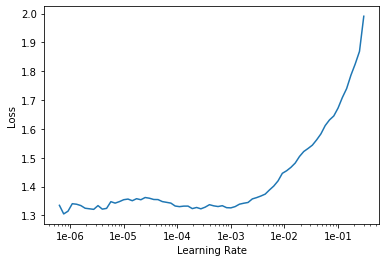

In [139]:
learn2.recorder.plot()

In [146]:
learn2.fit_one_cycle(2, max_lr=slice(1e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.119625,0.975842,0.343600,06:33
1,0.987466,0.910495,0.321100,06:43


In [147]:
learn2.save('learn2-stage-2')

## Task: Do the same steps on the MNIST database

In [92]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/Users/yani/.fastai/data/mnist_sample')

In [99]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, train='valid',valid='train',ds_tfms=tfms, size=28)
# I flip the vlidation and train so you will have a smaller set that you need to train. 

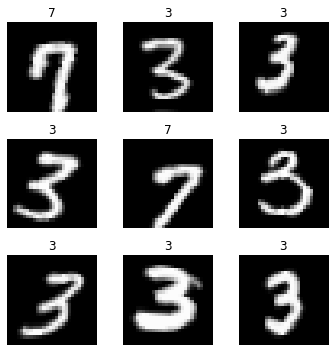

In [100]:
data.show_batch(rows=3, figsize=(5,5))


In [101]:
data

ImageDataBunch;

Train: LabelList (2038 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/yani/.fastai/data/mnist_sample;

Valid: LabelList (12396 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/yani/.fastai/data/mnist_sample;

Test: None